In [3]:
%matplotlib inline

from waveletAnalysis import waveletAnalysis as wave
import timecourseAnalysis as tca
from hdf5manager import hdf5manager as h5
from matplotlib import pyplot as plt
from wholeBrainPCA import *
import scipy
import math
from scipy import ndimage
from skimage.measure import label, regionprops
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.externals import joblib

plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import plotly
plotly.tools.set_credentials_file(username='brmullen', api_key='w9zNJSqbIzgDUYE9ET7R')

In [2]:
path = '/home/brian/Documents/data/Classifier/'
file = '170804_02_ica.hdf5'

h = h5(path + file)
print(h.keys())


['n_components', 'PCAtype', 'shape', 'cutoff', 'artifact_components', 'eig_mix', 'eig_val', 'eig_vec', 'expmeta', 'filter', 'flipped', 'mean', 'noise_components', 'pc_xcorr', 'roimask', 'thresholds', 'timecourses']


## Load data

(600, 6000)


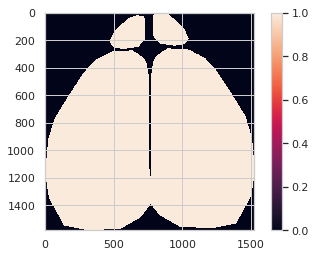

In [6]:
flipped = h.load('flipped')
tcourse = h.load('timecourses')

#flipped the inverted timeseries
tcourse = (np.multiply(tcourse.T, flipped)).T

#load mask
roimask = h.load('roimask')

print(tcourse.shape)





# for key, val in data.items():
#     print(key)
#     print(val)
# tcourse = h.load('ROI_timecourses')
# roi = h.load('domain_ROIs')
# # mask = h.load('roimask')
# # roi[np.where(mask==0)] = np.nan

# # mean = h.load('mean')
# # tcourse += mean

# # plt.plot(mean)
# # plt.show()

# plt.imshow(roi)
# plt.colorbar()
# plt.show()

plt.imshow(roimask)
plt.colorbar()
plt.show()

## Metrics for time information

The following metrics should be taken to build the classifier:

1. __Characterize the timeseries__
<br>
    a. Autocorrelation Lag1
<br>
    b. Standard Deviation
<br>
2. __Frequency analysis__: Range of frequencies from the longest region above the noise threshold
<br>
    a. Integrate the values above the noise cuttoff
<br>
    b. Find max SNR
<br>
    c. Average SNR
<br>
    d. Range of significance: Lowest/Highest frequencies
<br>
    e. Size of frequency span
<br>


In [7]:
def findContinBool(boolArray1D):
    nestDict = {}
    j, k = (-1, 0)
    usek = True
    for i in range(len(boolArray1D)):
        if boolArray1D[i] and not boolArray1D[i-1]:
            j += 1 
            if j >= 1:
                nestDict['region' + str(j-1)]['length'] = k
            k = 0
            nestDict['region' + str(j)] = {}
            nestDict['region' + str(j)]['freq.index'] = [] 
            nestDict['region' + str(j)]['freq.index'].append(i)
            k += 1
        if boolArray1D[i] and boolArray1D[i-1]:
            if i == 1:
                j += 1
                nestDict['region' + str(j)] = {}
                nestDict['region' + str(j)]['freq.index'] = []
                nestDict['region' + str(j)]['freq.index'].append(i-1)
                nestDict['region' + str(j)]['freq.index'].append(i)
            elif i == 0:
                pass
            else:
                k += 1
                nestDict['region' + str(j)]['freq.index'].append(i)

    if j != -1:
        nestDict['region' + str(j)]['length'] = k
    
    return nestDict

def findSig():
    ratio = np.squeeze(w.gws/w.gws_sig)
    index = (ratio > 1)
    return ratio, index

def approxIntegrate(index, freq, power, sigcutoff): 
    #power
    diff = np.squeeze(power - sigcutoff) #integrate only significant area
    #freq
    if index[-1] != freq.shape[0]-1: # default to right sided estimation
        offset = [x+1 for x in index]
        binsz = freq[index] - freq[offset]
    else:
        offset = [x-1 for x in index]
        binsz = freq[offset] - freq[index]
        
    return np.sum(binsz * diff[index])

def temporalCharacterize(sigfreq, ratio, freq):
    for k in sigfreq.keys():
        sigfreq[k]['freq.maxsnr'] = np.nanmax(ratio[sigfreq[k]['freq.index']])
        sigfreq[k]['freq.maxsnr.freq'] = np.nanargmax(ratio[sigfreq[k]['freq.index']])
        sigfreq[k]['freq.avgsnr'] = np.nanmean(ratio[sigfreq[k]['freq.index']])
        sigfreq[k]['freq.range.low'] = freq[sigfreq[k]['freq.index'][-1]] 
        sigfreq[k]['freq.range.high'] = freq[sigfreq[k]['freq.index'][0]]
        if sigfreq[k]['freq.range.low'] and not sigfreq[k]['freq.range.high']:
                sigfreq[k]['freq.range.high'] = 5
        if sigfreq[k]['freq.range.high'] and not sigfreq[k]['freq.range.low']:
                sigfreq[k]['freq.range.low'] = 0                
        sigfreq[k]['freq.rangesz'] = (sigfreq[k]['freq.range.high'] - sigfreq[k]['freq.range.low'])
        sigfreq[k]['freq.integrate'] = approxIntegrate(index = sigfreq[k]['freq.index'], freq = w.flambda, 
                                                  power = w.gws, sigcutoff = w.gws_sig)

    return sigfreq

def sortNestedDict(nestDict, sortkey = 'freq.rangesz'):
    sortDict = []
    for k in nestDict.keys(): sortDict.append(k)
#     sortDict = sorted(sortDict, key=lambda x: (sigfreq[x]['length']), reverse =True)
    sortDict = sorted(sortDict, key=lambda x: (nestDict[x][sortkey]), reverse =True)

    return sortDict

Domian number : 23
Assessing wavelet mother MORLET at paramter 4
Auto-correlation value: 0.8513
Low frequency:  0.220970869121
High freqency:  2.72626933166


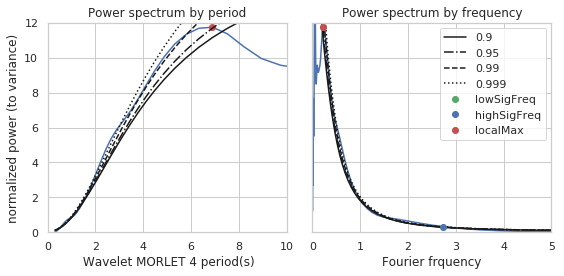

['region0', 'region1']
{'region1': {'freq.maxsnr.freq': 5, 'freq.range.low': 0.22097086912079608, 'freq.integrate': 0.38423426793368592, 'freq.avgsnr': 1.0987617821652937, 'freq.maxsnr': 1.1887530403102378, 'freq.range.high': 0.96388176587996288, 'length': 18, 'freq.rangesz': 0.74291089675916677, 'freq.index': [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]}, 'region0': {'freq.maxsnr.freq': 3, 'freq.range.low': 1.6210494433137621, 'freq.integrate': 0.10018288101888323, 'freq.avgsnr': 1.173433172266144, 'freq.maxsnr': 1.2514530287990036, 'freq.range.high': 2.7262693316631443, 'length': 7, 'freq.rangesz': 1.1052198883493822, 'freq.index': [7, 8, 9, 10, 11, 12, 13]}}


In [8]:
#single index
good_bad_index = [23]#, 150, 170]
# plt.imshow(roi)
# plt.show()
fps = 10
for index in good_bad_index:
    print('Domian number :', index)
    w = wave(data = tcourse[index],
             fps = fps,
             mother = 'MORLET',
             param = 4,
             siglvl = 0.95,
             verbose = True,
             plot=True)
    w.globalWaveletSpectrum()
    
    ratio, index = findSig()
    k = findContinBool(index)
    k = temporalCharacterize(k, ratio, w.flambda)
    l = sortNestedDict(k)
    print(l)
    print(k)
    

In [9]:
# autocorr = np.zeros((tcourse.shape[0])) * np.nan
# maxfreq = np.zeros(tcourse.shape[0]) * np.nan
# lowfreq = np.zeros(tcourse.shape[0]) * np.nan

# for i, tc in enumerate(tcourse):
#     if (i%100) == 0:
#         print(i)
#     autocorr[i] = tca.lagNAutoCorr(w.data, 1)
#     w = wave(data = tc, fps = 10,verbose = False, plot = False)
#     w.globalWaveletSpectrum()
#     if hasattr(w, 'gws_lo_high_freq'):
#         maxfreq[i] = w.gws_lo_high_freq[0][0]
#         lowfreq[i] = w.gws_lo_high_freq[1][0]


In [ ]:
# lowfreq[np.where(lowfreq == 5)] = np.nan

# plt.plot(autocorr[:,0], label = 'autocorr1')
# plt.plot(autocorr[:,1], label = 'autocorr2')
# plt.plot(autocorr[:,2], label = 'autocorr3')
# plt.plot(maxfreq, label = 'lowfreq')
# plt.plot(lowfreq, label = 'highfreq')

# plt.scatter(np.arange(tcourse.shape[0]), -1/10*noise, marker='.', color = 'k', label = 'noise')
# plt.xlim([0,300])
# plt.legend()
# plt.show()

## Metrics for spatial analysis

The following metrics should be taken to build the classifier:

1. __Characterize the center of mass__
<br>
    a. Autocorrelation Lag1
<br>
    b. Standard Deviation
<br>
2. __Largest blob characterization__
<br>
    a. Percent 'mass' under the largest blob
<br>
    b. Percent of the masked region the largest blob composes
<br>
    c. Major/minor axis
<br>
    d. Orientation/ Angle of rotation for major axis
<br>
    e. Eccentricity 

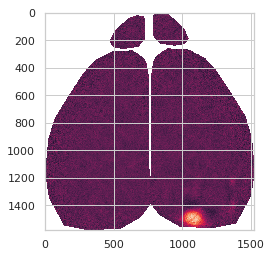

In [9]:
pc_id = 15
#load mask
roimask = h.load('roimask')
#load eig_vec
eig_vec = h.load('eig_vec')
eigenbrain = rebuildEigenbrain(eig_vec, pc_id, roimask=roimask, eigb_shape=None, 
    maskind=None)

flipped = h.load('flipped')

thresh = h.load('thresholds')

plt.imshow(eigenbrain)
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in less



xcom:  921.318674839
ycom:  774.159392174


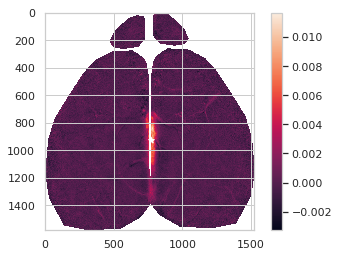

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:138: RuntimeWarning:

invalid value encountered in less



AttributeError: module 'scipy.ndimage' has no attribute 'regionprops'

In [11]:
def centerOfMass(eigenbrain, threshold=None, verbose=True, plot=True):
    eigen = eigenbrain.copy()
    if threshold is not None:
        eigen[eigen < threshold] = np.nan
    x, y = np.where(np.isnan(eigen)==False)

    #total sum
    totalmass = np.nansum(np.abs(eigen))
    #weighted sum
    sumrmx = 0
    sumrmy = 0
    for i in range(x.shape[0]):
        sumrmx += np.abs(eigenbrain[x[i],y[i]])*x[i]
        sumrmy += np.abs(eigenbrain[x[i],y[i]])*y[i]

#     plt.imshow(eigen)
#     plt.show()
    
    comx = sumrmx/totalmass
    comy = sumrmy/totalmass
   
    if verbose:
        print('xcom: ', comx)
        print('ycom: ', comy)

    if plot:
        plt.imshow(eigenbrain)
        plt.colorbar()
        plt.scatter(comy, comx, color='w', marker='*' )
        plt.show()

    return comx, comy

def xyProjectMax(eigenbrain, verbose=True, plot=True):
    xmean = np.nanmean(eigenbrain, axis = 1)
    xmax = np.nanargmax(xmean)
    
    ymean = np.nanmean(eigenbrain, axis = 0)
    ymax = np.nanargmax(ymean)

    if verbose:
        print('xmax: ', xmax)
        print('ymax: ', ymax)
        
    if plot:
        plt.plot(ymean)
        plt.plot(xmean)
        plt.scatter([xmax,ymax],[0,0], color = 'r')
        plt.show()
        
        
        plt.imshow(eigenbrain)
        plt.colorbar()
        plt.scatter(ymax, xmax, color='w', marker='*' )
        plt.show()

    return xmax, ymax
    
def positionMaxIntensity(eigenbrain, verbose=True, plot=True):
    amax = np.nanmax(eigenbrain)
    xamax = np.where(eigenbrain == amax)[0]
    yamax = np.where(eigenbrain == amax)[1]
    if verbose:
        print('x amax: ', xamax)
        print('y amax: ', yamax)
        
    if plot:
        plt.imshow(eigenbrain)
        plt.colorbar()
        plt.scatter(yamax, xamax, color='w', marker='*' )
        plt.show()
    return xamax, yamax
    
def majorMinorAxis(x, y, scale=50, rotsum=False, plot=False):
    
    #Determine center of mass and planes of symmetry of a binary masked region.
    xthresh = x - np.mean(x) #demean the data
    ythresh = y - np.mean(y)
    
    coords = np.vstack([xthresh, ythresh])
    
    cov = np.cov(coords) #find the covarience
    evals, evecs = np.linalg.eig(cov) #take the eigenvecotors of the covarince of the x, y coordinates
    sort_indices = np.argsort(evals)[::-1] #sort the two eigenvectors (x, y  covarience)
    evec1, evec2 = evecs[:, sort_indices]
    x_v1, y_v1 = evec1  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evec2
    
    if plot:
        plt.plot(ythresh + np.mean(y), xthresh + np.mean(x), 'k.')
        plt.plot([y_v1*-scale+ np.mean(y), y_v1*scale+ np.mean(y)],
                 [x_v1*-scale+ np.mean(x), x_v1*scale+ np.mean(x)],
                  color='blue')
        plt.plot([y_v2*-scale+ np.mean(y), y_v2*scale+ np.mean(y)],
                 [x_v2*-scale+ np.mean(x), x_v2*scale+ np.mean(x)],
                  color='red')
    #     ax.plot3D([x_v3*-scale+ np.mean(x), x_v3*scale+ np.mean(x)],
    #              [y_v3*-scale+ np.mean(y), y_v3*scale+ np.mean(y)],
    #              [z_v3*-scale+ np.mean(z), z_v3*scale+ np.mean(z)], color='green')
    #     plt.axis('equal')
    #     plt.gca().invert_yaxis()  # Match the image system with origin at top left
    #     ax.view_init(60, 35)
        plt.gca().invert_yaxis()
        plt.show
    
    if rotsum:
    # rotate the image based on major axis, project along the major and minor axis
        angle = math.degrees(math.atan(y_v1/x_v1))

        rot = rotate(eigenbrain,-angle, resize = True, cval=np.nan )

        rotx = np.nanmean(test, axis =0)
        roty = np.nanmean(test, axis =1)
        
        if plot:
            plt.imshow(test)
            plt.show()
            
            plt.plot(rotx, label='rotx')
            plt.plot(roty, label = 'roty')
            plt.legend()
            plt.show()
    
    major = [[x_v1*-scale + np.mean(x),x_v1*scale + np.mean(x)],
             [y_v1*-scale + np.mean(y),y_v1*scale + np.mean(y)]]

    minor = [[x_v2*-scale + np.mean(x),x_v2*scale + np.mean(x)],
             [y_v2*-scale + np.mean(y),y_v2*scale + np.mean(y)]]
    
    if rotsum:
        return major, minor, rotx, roty
    else:
        return major, minor

def spatialCharacterize(eigenbrain, pc, threshold, verbose = False, plot = False):
    eigen = eigenbrain.copy()
#     eigen[eigen == np.nan] = 0
    eigen[eigen < threshold] = np.nan  
    x, y = np.where(np.isnan(eigen)==False)
    image = np.zeros_like(eigenbrain)
    image[x,y] = 1
    image = scipy.ndimage.median_filter(image, size=5)
    label_img = label(image)
    regions = regionprops(label_image)
    totalmass = np.nansum(np.abs(eigenbrain))
    
    domregion = {}
    
    for i, props in enumerate(regions):
        domregion['region' + str(i)] = {}
        regcoord = props.coords
        intensity = np.zeros_like(regcoord[:,0]).astype('float16')
        for j, coord in enumerate(regcoord):
            intensity[j] = eigenbrain[coord[0], coord[1]]
        
        if plot:
            plt.scatter(y, x, color = (0,0,0,0.05), marker='.')
            plt.scatter(regcoord[:,1], regcoord[:,0], c=intensity, cmap='jet')
            plt.gca().invert_yaxis()
            plt.show()
        
#         domregion['region' + str(i)]['pc_id']=pc
        domregion['region' + str(i)]['threshold.area']=props.area
        domregion['region' + str(i)]['threshold.perc']=props.area/np.sum(image)
        domregion['region' + str(i)]['mass.total']=totalmass
        domregion['region' + str(i)]['mass.region']=np.nansum(intensity)
        domregion['region' + str(i)]['mass.perc']=np.nansum(intensity)/totalmass
        domregion['region' + str(i)]['region.centroid.0']=props.centroid[0]
        domregion['region' + str(i)]['region.centroid.1']=props.centroid[1]
        domregion['region' + str(i)]['region.orient']=props.orientation
        domregion['region' + str(i)]['region.majaxis']=props.major_axis_length
        domregion['region' + str(i)]['region.minaxis']=props.minor_axis_length
        domregion['region' + str(i)]['region.extent']=props.extent
        domregion['region' + str(i)]['region.eccentricity']=props.eccentricity
        if props.minor_axis_length > 0:
            domregion['region' + str(i)]['region.majmin.ratio']=props.major_axis_length/props.minor_axis_length

        if verbose:
            print('Threshold area: ', props.area)
            print('Percent threshold area assessed: ', props.area/np.sum(image))
            print('\nTotalmass: ', totalmass)
            print('Areamass: ', np.nansum(intensity))
            print('Percent mass: ', np.nansum(intensity)/totalmass)
            print('\nCentroid: ', props.centroid)
            print('Orientation :', props.orientation)
            print('Major axis: ', props.major_axis_length)
            print('Minor axis: ', props.minor_axis_length)
            print('Extent: ',props.extent)
            print('Eccentricty: ',props.eccentricity)

    return domregion

    
pc_id =1

eigenbrain = rebuildEigenbrain(eig_vec, pc_id, roimask=roimask, eigb_shape=None, 
    maskind=None)

eigenbrain = eigenbrain * flipped[pc_id]

comx, comy = centerOfMass(eigenbrain, 
                          threshold=thresh[pc_id], 
                          plot=True)
# xm, ym = xyProjectMax(eigenbrain)
# xa, ya = positionMaxIntensity(eigenbrain)

k = spatialCharacterize(eigenbrain, pc=pc_id, threshold=thresh[pc_id])
print(k)
l = sortNestedDict(k, sortkey = 'mass.perc')
print(l)


# xmax, ymax, major, minor = eigenbrainCOM(eigenbrain, roimask, thresh[pc_id])

# plt.imshow(eigenbrain)
# plt.colorbar()
# plt.scatter(ymax, xmax, color='w', marker='*' )
# # plt.plot([x_v2*-scale+ np.mean(x), x_v2*scale+ np.mean(x)],
# #              [y_v2*-scale+ np.mean(y), y_v2*scale+ np.mean(y)]
# plt.plot(major[1], major[0], color = 'black')
# plt.plot(minor[1], minor[0], color = 'red')

# plt.show()

## Building the dataframe


In [9]:
import pandas as pd
import numpy as np

for i in range(eig_vec.shape[1]):
    if i == 0:
        data = pd.DataFrame()
    if i%25 == 0:
        print('Working on {0} of {1} PCs'.format(i, eig_vec.shape[1]))
    pc_id = i
    
    #Spatial
    #rebuild the eigenbrain
    eigenbrain = rebuildEigenbrain(eig_vec, pc_id, roimask=roimask, eigb_shape=None, 
        maskind=None)
    eigenbrain = eigenbrain * flipped[i]
    
    #general characteristics
    std = np.nanstd(eigenbrain)
    avg = np.nanmean(eigenbrain)
    mina = np.nanmin(eigenbrain)
    maxa = np.nanmax(eigenbrain)
    comxall, comyall = centerOfMass(eigenbrain, 
                          plot=False, verbose = False)
    comxdom, comydom = centerOfMass(eigenbrain, 
                              threshold=thresh[i], 
                              plot=False, verbose = False)
    
    #characterize the largest domain in the threshold
    k = spatialCharacterize(eigenbrain, pc=pc_id, threshold=thresh[i], plot = False)
#     print(k)
    l = sortNestedDict(k, sortkey = 'mass.perc')
#     print(l)
    
    if len(l) > 0:
        for key, val in k[l[0]].items():
            data.at[i, key] = val
    data.at[i,'spatial.std'] = std
    data.at[i,'spatial.avg'] = avg        
    data.at[i,'spatial.min'] = mina        
    data.at[i,'spatial.max'] = maxa        
    data.at[i,'spatial.COMall.x'] = comxall      
    data.at[i,'spatial.COMall.y'] = comyall        
    data.at[i,'spatial.COMdom.x'] = comxdom      
    data.at[i,'spatial.COMdom.y'] = comydom
    
    #Temporal
    #run wavelet analysis on it
    w = wave(data = tcourse[i],
             fps = fps,
             mother = 'MORLET',
             param = 4,
             siglvl = 0.95,
             verbose = False,
             plot=False)
    w.globalWaveletSpectrum()
    
    ratio, index = findSig()
    m = findContinBool(index)
    m = temporalCharacterize(m, ratio, w.flambda)
    n = sortNestedDict(m, sortkey = 'freq.rangesz')
    if len(n) > 0:
        for key, val in m[n[0]].items():
            if key == 'freq.index':
                pass
            else:
                data.at[i, key] = val
    data.at[i,'temporal.autocorr'] = tca.lagNAutoCorr(tcourse[i], 1)
    data.at[i,'temporal.min'] = np.nanmin(tcourse[i])
    data.at[i, 'temporal.max'] = np.nanmax(tcourse[i])
    data.at[i,'temporal.std'] = np.nanstd(tcourse[i])

data.sort_index()
data.head()

Working on 0 of 600 PCs


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:138: RuntimeWarning:

invalid value encountered in less



Working on 25 of 600 PCs
Working on 50 of 600 PCs
Working on 75 of 600 PCs
Working on 100 of 600 PCs
Working on 125 of 600 PCs
Working on 150 of 600 PCs
Working on 175 of 600 PCs
Working on 200 of 600 PCs
Working on 225 of 600 PCs
Working on 250 of 600 PCs
Working on 275 of 600 PCs
Working on 300 of 600 PCs
Working on 325 of 600 PCs
Working on 350 of 600 PCs
Working on 375 of 600 PCs
Working on 400 of 600 PCs
Working on 425 of 600 PCs
Working on 450 of 600 PCs
Working on 475 of 600 PCs
Working on 500 of 600 PCs
Working on 525 of 600 PCs
Working on 550 of 600 PCs
Working on 575 of 600 PCs


,region.orient,mass.region,region.minaxis,mass.perc,threshold.perc,region.majmin.ratio,mass.total,region.centroid.0,region.centroid.1,threshold.area,...,freq.integrate,length,freq.range.low,freq.maxsnr.freq,freq.range.high,freq.avgsnr,temporal.autocorr,temporal.min,temporal.max,temporal.std
0,-1.368896,76.250,79.660105,0.107861,0.799976,4.643107,706.929045,1336.699469,800.470584,13190.0,...,0.112841,12.0,0.963882,4.0,2.500000,1.230580,0.971156,-13.771223,74.819717,8.508549
1,1.546649,76.875,42.164554,0.113384,0.681059,10.680319,678.003272,934.099740,784.702044,13455.0,...,0.038031,10.0,1.250000,4.0,2.726269,1.170509,0.981528,-13.635504,48.029102,7.621354
2,-0.371672,59.875,50.910356,0.077699,0.939667,4.973272,770.597267,1516.433888,958.887148,9189.0,...,0.035343,14.0,0.743254,3.0,2.292510,1.113086,0.987177,-10.480838,45.497751,6.864244
3,-0.429769,116.125,141.910564,0.184886,1.000000,1.342569,628.089228,913.203102,529.139303,21019.0,...,0.057386,7.0,1.621049,3.0,2.726269,1.149652,0.948855,-16.242683,32.889215,6.703320
4,0.408247,117.750,149.567445,0.190399,1.000000,1.234151,618.439277,902.624283,1006.996784,21455.0,...,0.044102,8.0,1.486509,4.0,2.726269,1.106510,0.953928,-13.964150,32.982635,6.567101


In [10]:
#Save file for future manipulations
tsv_output_file = '/home/brian/Documents/data/Classifier/' + file[:9] + '_ica_metrics.tsv'
data.to_csv(tsv_output_file, sep = '\t')


The metrics that are currently being used are:

### Spatial measures of ICs:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ** basic measures **
1. **spatial standard deviation ['spatial.std']**
2. spatial average data.at[i,'spatial.avg'] _not needed_
3. spatial global minima ['spatial.min']        
4. **spatial global maxima ['spatial.max']**

    ** center of mass/centroid ** _all similar measures, choose only one that works well_
5. spatial center of mass (x value) of whole IC ['spatial.COMall.x']      
6. spatial center of mass (y value) of whole IC ['spatial.COMall.y']      
7. spatial center of mass (x value) of only thresholded IC domain ['spatial.COMdom.x']      
8. spatial center of mass (y value) of only thresholded IC domain ['spatial.COMdom.y']
9. **_the first dimension of the centroid of the largest masked domain, non-weighted value ['region.centroid.0']_**
10. **_the second dimension of the centroid of the largest masked domain, non-weighted value ['region.centroid.1']_**

    ** size of domain **
11. number of pixels in the largest of the thresholded IC domains ['threshold.area'] in pixels

    ** weight of domain/IC component **
12. sum of the absolute value of all pixels within the IC ['mass.total']
13. **sum of the intensity vales in the thresholded IC domian ['mass.region']**
14. precent of intensity values in the thresholed IC domain with respect to the absolute value of the sum of all values ['mass.perc'] _depends on ['mass.total]_

    ** domain properties **
15. the angle of the major axis through the largest masked domain ['region.orient']
16. the length of the major axis through the largest masked domain ]['region.majaxis']
17. **_the length of the minor axis through the largest masked domain ]['region.minaxis']_**

    ** shape of domain ** _all are dependent on the minor and major axis_
18. the proportion of the pixels in the bounding box of the region that are also in the region ['region.extent']
19. the eccentricity of the ellipse that has the same second-moments as the region ['region.eccentricity']
20. the ratio of the major/minor axis of the region ['region.majmin.ratio']

### Temporal measures of ICs:
signal = frequency power based on wavlet analysis after running globalWaveletSpectrum

noise = null hypothesis of red noise from globalWaveletSpectrum

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ** basic measures **
1. first autocorrelation ['temporal.autocorr'] _used in noise component selection_
2. timeseries minimum ['temporal.min']
3. **timeseries maximum ['temporal.max']**
4. **timeseries standard deviation ['temporal.std']**

    ** global Wavelet Spectrum SNR/integration **
5. the largest signal to noise ratio within the longest frequency segment ['freq.maxsnr']
6. the average signal to noise ratio within the longest frequency segment ['freq.avgsnr']
7. the lowest frequency (highest period) of the longest frequency segment ['freq.range.low']
8. **the higest frequency (lowest period) of the longest frequency segment ['freq.range.high']**
9. the distance beteween the highest and lowest frequencies ['freq.rangesz']
10. **the approximate integration of the signal above the noise threshold (default using right sided estimation) ['freq.integrate']**

<div class="alert alert-block alert-success">
<b>Values selected for classifier:</b>
<p>**Spatial** <p>
1. spatial.std  
2. spatial.max     
3. mass.region      
4. region.minaxis    

<p> **Temporal** <p>
1. temporal.std   
2. temporal.max      
3. freq.range.high   
4. freq.integrate  
5. freq.rangesz

</div>


## Exploration of data

In [4]:
import pandas as pd

#Open file
path = '/home/brian/Documents/data/Classifier/'
file = '170804_02_ica.hdf5'

tsv_output_file = path + file[:9] + '_ica_metrics.tsv'
data = pd.DataFrame.from_csv(tsv_output_file, sep = '\t', index_col='exp_ic')

print(data.head())

/Users/jcrndm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


FileNotFoundError: [Errno 2] File b'/home/brian/Documents/data/Classifier/170804_02_ica_metrics.tsv' does not exist: b'/home/brian/Documents/data/Classifier/170804_02_ica_metrics.tsv'

In [3]:
%matplotlib inline

col_list = list(data)

#puts the paramter on a scale of 0 to 1

datacopy = data.drop('age', axis =1).copy()
datacopy -= datacopy.min()
datacopy /= datacopy.max()
datacopy['age'] = data['age']
data = datacopy.fillna(value=0)
del datacopy


print(data.head())

NameError: name 'data' is not defined

In [1]:

notnoise_index = data.loc[data['noise'] < 1].index
data = data.loc[notnoise_index]

# def sepHist(data, artifact, noise):
    
#     noisedf = data[classify == 2]
#     artifactdf = data[classify == 1]
#     sigdf = data[classify == 0]
#     return noisedf, artifactdf, sigdf

# noisedf, artifactdf, sigdf = sepHist(data, artifact, noise)

artifact_index = data.loc[data['artifact'] == 1].index
signal_index = data.loc[data['signal'] == 1].index

for col in col_list:
    print(col)

    fig , ax1 = plt.subplots()
    ax1.hist(data.loc[artifact_index, col], bins = 25, alpha = 0.5, label ='artifact', color = 'g')
    ax1.grid(False)         
    ax1.set_xlabel('Values')
    ax1.set_ylabel('# of instances', color = 'green')

    ax2 = ax1.twinx()
    ax2.hist(data.loc[signal_index, col], bins = 25, alpha = 0.5, label ='signal', color = 'b')
    ax2.set_ylabel('# of instances', color = 'blue')
    ax2.grid(False)
#     ax2.hist(noisedf[col].dropna(), bins = 25, alpha = 0.5, label ='noise', color = 'r')
#     ax2.set_xlabel('Values')
#     ax2.set_ylabel('# of instances', color = 'red')
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()

    
    
#     fig = plt.figure()
#     x = data.loc[(data[col]) & (noise[:X_reduced_tsne.shape[0]] == 0)]
#     y = data.iloc[[noise[:X_reduced_tsne.shape[0]] == 1],col]
#     ax = fig.add_subplot(111)
#     _ = ax.hist(x)
#     _ = ax.hist(y, color ='red', alpha=0.3)
    
# #     data[col,np.where(noise[:X_reduced_tsne.shape[0]] == 0)]
# #     d
#     plt.show()

# for col in col_list:
#     print(col)
#     data3[col].apply(np.log2).hist(by = noise[:X_reduced_tsne.shape[0]])
#     plt.show()


NameError: name 'data' is not defined

In [19]:

# data2.at[np.where(classify == 2)[0], 'class'] = 'noise'
# data2.loc[np.where(classify == 1)[0], 'class'] = 'artifact'
# data2.loc[np.where(classify == 0)[0], 'class'] = 'signal'

data.groupby('signal').mean()

,noise,artifact,spatial.std,spatial.avg,spatial.min,spatial.max,spatial.n.domains,region.centroid.0,mass.total,mass.perc,...,temporal.n.freq,freq.maxsnr.freq,freq.integrate,freq.range.low,freq.avgsnr,freq.maxsnr,freq.range.high,length,freq.rangesz,age
signal,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,1.0,0.386324,0.473778,0.728189,0.419358,0.113598,0.499133,0.568878,0.123968,...,0.354167,0.106250,0.098305,0.184149,0.122062,0.112559,0.297934,0.191789,0.280664,21.0
1.0,0.0,0.0,0.494932,0.455041,0.889280,0.191642,0.076139,0.633578,0.601993,0.358193,...,0.391429,0.128889,0.038060,0.233321,0.039282,0.035969,0.459584,0.240224,0.534103,21.0


In [21]:
data.groupby('signal').std()

,noise,artifact,spatial.std,spatial.avg,spatial.min,spatial.max,spatial.n.domains,region.centroid.0,mass.total,mass.perc,...,temporal.n.freq,freq.maxsnr.freq,freq.integrate,freq.range.low,freq.avgsnr,freq.maxsnr,freq.range.high,length,freq.rangesz,age
signal,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.0,0.190935,0.095730,0.219906,0.259746,0.175822,0.294090,0.335673,0.197977,...,0.173257,0.097721,0.217320,0.214033,0.243343,0.232338,0.260276,0.117830,0.254541,0.0
1.0,0.0,0.0,0.144310,0.121361,0.082755,0.132039,0.116214,0.231641,0.196546,0.204295,...,0.152531,0.124688,0.051828,0.145835,0.060330,0.081041,0.156781,0.147535,0.224458,0.0


## Over-sampling using SMOTE

from this article: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

With our training data created, I’ll up-sample the no-subscription using the SMOTE algorithm(Synthetic Minority Oversampling Technique). At a high level, SMOTE:

1. Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
2. Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

We are going to implement SMOTE in Python.

In [9]:
from imblearn.over_sampling import SMOTE

y = data.loc[:,'signal'].values

# y = np.squeeze(pd.DataFrame(np.ndarray.astype(y, int), columns=['signal']))
X = data.loc[:, data.columns != 'signal'].fillna(value=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

#augment your data
os = SMOTE(random_state=42)

columns = X_train.columns
os_data_X, os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data = os_data_y, columns =['signal'])

print('Length of data augmentation:', len(os_data_X))
print('Number of addition singal points: {0} \t\tProportion: {1}'.format(len(os_data_y[os_data_y['signal'] == 1]), len(os_data_y[os_data_y['signal'] == 1])/len(os_data_X)))
print('Number of addition non-singal points: {0} \tProportion: {1}'.format(len(os_data_y[os_data_y['signal'] == 0]), len(os_data_y[os_data_y['signal'] == 0])/len(os_data_X)))


Length of data augmentation: 244
Number of addition singal points: 122 		Proportion: 0.5
Number of addition non-singal points: 122 	Proportion: 0.5


## Recursive Feature Elimination

Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [14]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics

logreg = LogisticRegression(solver='lbfgs')

data_final_vars = X.columns.values.tolist()
y_vars = ['signal']

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())

print('Support\tRanking\tVariable')
for i, var in enumerate(data_final_vars):
    print(rfe.support_[i], '\t',rfe.ranking_[i],'\t', var)

new_vars = X.columns.values[rfe.ranking_ == 1].tolist()
# new_vars.append('class')
print(new_vars)

Support	Ranking	Variable
False 	 19 	 noise
True 	 1 	 artifact
True 	 1 	 spatial.std
False 	 3 	 spatial.avg
True 	 1 	 spatial.min
True 	 1 	 spatial.max
False 	 15 	 spatial.n.domains
True 	 1 	 region.centroid.0
False 	 10 	 mass.total
True 	 1 	 mass.perc
False 	 9 	 region.centroid.1
True 	 1 	 mass.region
True 	 1 	 region.minaxis
True 	 1 	 region.majaxis
True 	 1 	 region.orient
True 	 1 	 threshold.area
True 	 1 	 threshold.perc
True 	 1 	 region.extent
True 	 1 	 region.majmin.ratio
True 	 1 	 region.eccentricity
True 	 1 	 spatial.COMall.x
False 	 6 	 spatial.COMall.y
False 	 2 	 spatial.COMdom.x
False 	 12 	 spatial.COMdom.y
False 	 5 	 temporal.autocorr
False 	 8 	 temporal.min
True 	 1 	 temporal.max
False 	 4 	 temporal.std
False 	 11 	 temporal.n.freq
True 	 1 	 freq.maxsnr.freq
False 	 13 	 freq.integrate
False 	 16 	 freq.range.low
False 	 17 	 freq.avgsnr
False 	 14 	 freq.maxsnr
False 	 7 	 freq.range.high
True 	 1 	 length
True 	 1 	 freq.rangesz
False 	 18 	 age

/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.5/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



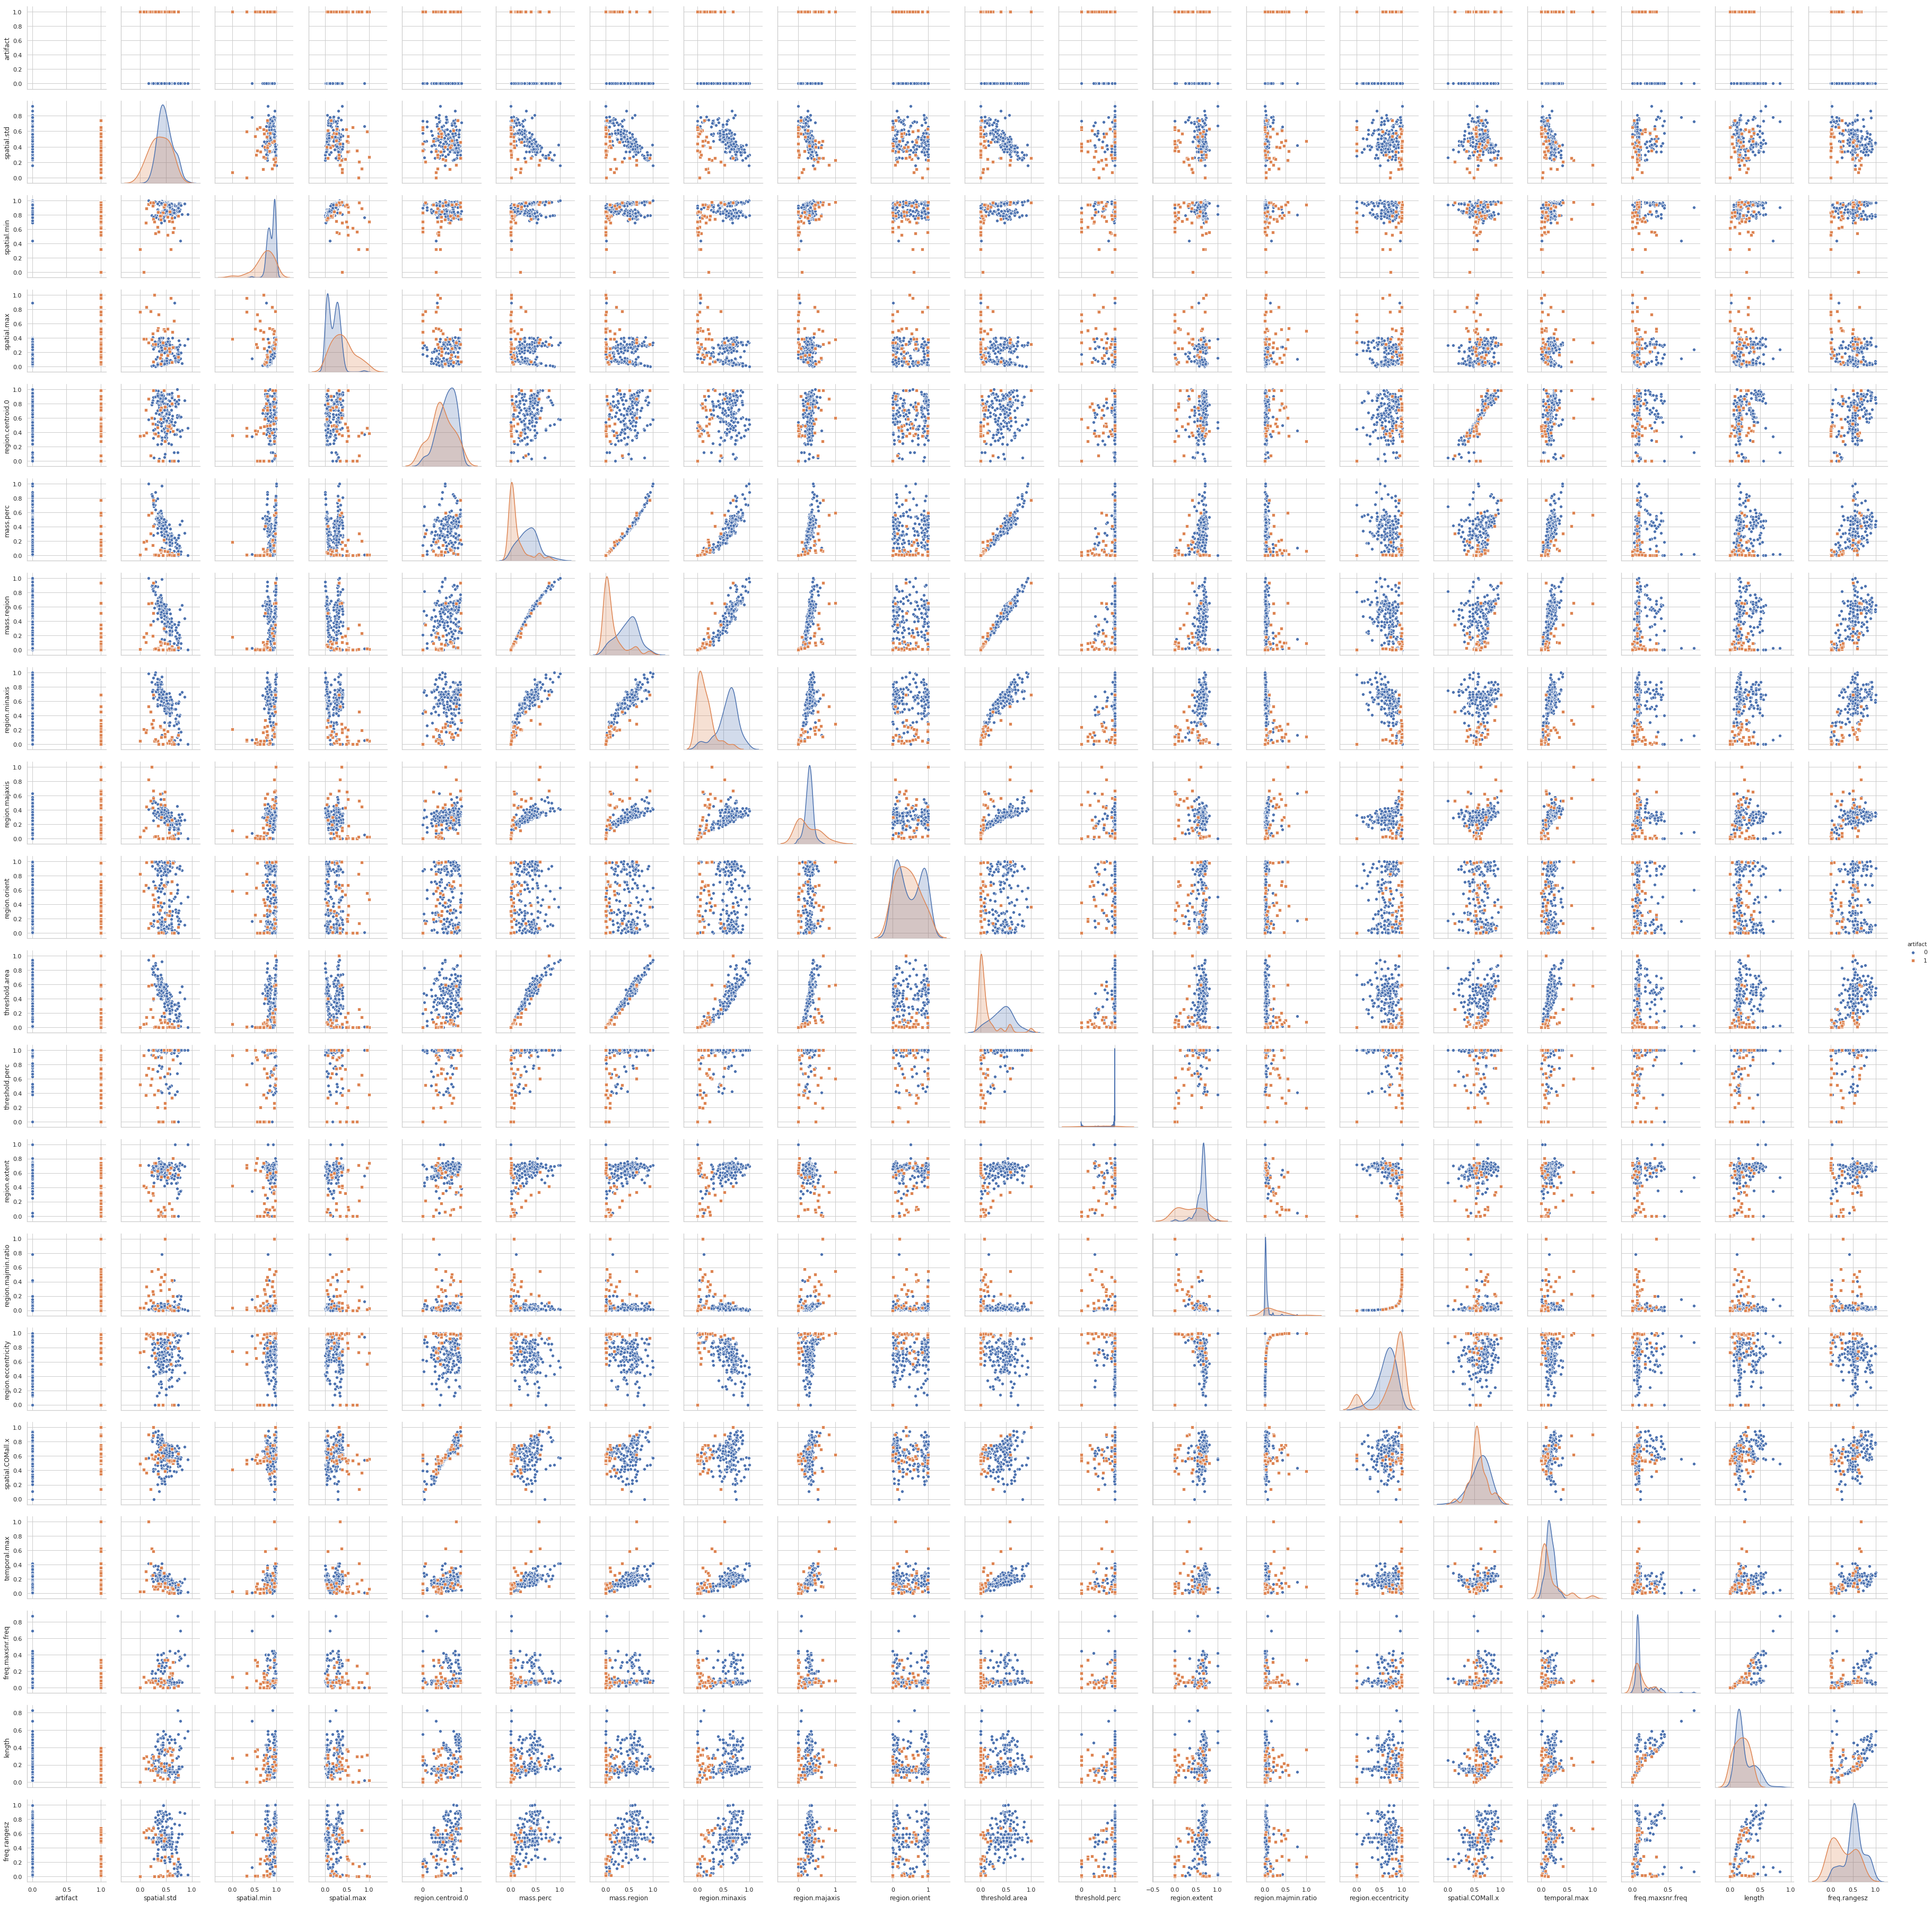

In [28]:


# metrics = ['spatial.std', 'spatial.max', 'mass.region', 'region.minaxis', 
#            'temporal.std', 'temporal.max', 'freq.range.high', 'freq.integrate', #'freq.rangesz', 
#            'class']

# data2.at[np.where(classify == 2)[0], 'class'] = 'noise'

data3 = data[new_vars]

# Both temporal and spatial metrics visualize  
sns.pairplot(data3, 
             diag_kind="kde", 
             markers=["o", "s"], 
             hue_order = [0, 1], hue='artifact')

plt.savefig('/home/brian/Documents/figures/p21_pairplot.png')
plt.show()

In [15]:
import statsmodels.api as sm
# del new_vars[-1]
                #spatial metrics
new_new_vars = ['region.orient', 'mass.region', 'region.minaxis',
                'threshold.area', 'region.majaxis',
                'spatial.std', 'spatial.min', 'spatial.max', 
                #temporal metrics
                'freq.maxsnr.freq', 'temporal.autocorr', 'temporal.min', 'temporal.max']


logit_model=sm.Logit(y,X[new_vars])
results=logit_model.fit()
print(results.summary2())

# take out the non-significant variables?  What about running this on all the values that we measured

         Current function value: 0.000000
         Iterations: 35
                                 Results: Logit
Model:                    Logit                Pseudo R-squared:     1.000      
Dependent Variable:       y                    AIC:                  40.0000    
Date:                     2019-04-03 10:47     BIC:                  106.6544   
No. Observations:         207                  Log-Likelihood:       -1.5760e-06
Df Model:                 19                   LL-Null:              -89.132    
Df Residuals:             187                  LLR p-value:          6.7957e-28 
Converged:                0.0000               Scale:                1.0000     
No. Iterations:           35.0000                                               
--------------------------------------------------------------------------------
                     Coef.     Std.Err.     z    P>|z|     [0.025       0.975]  
----------------------------------------------------------------------------

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



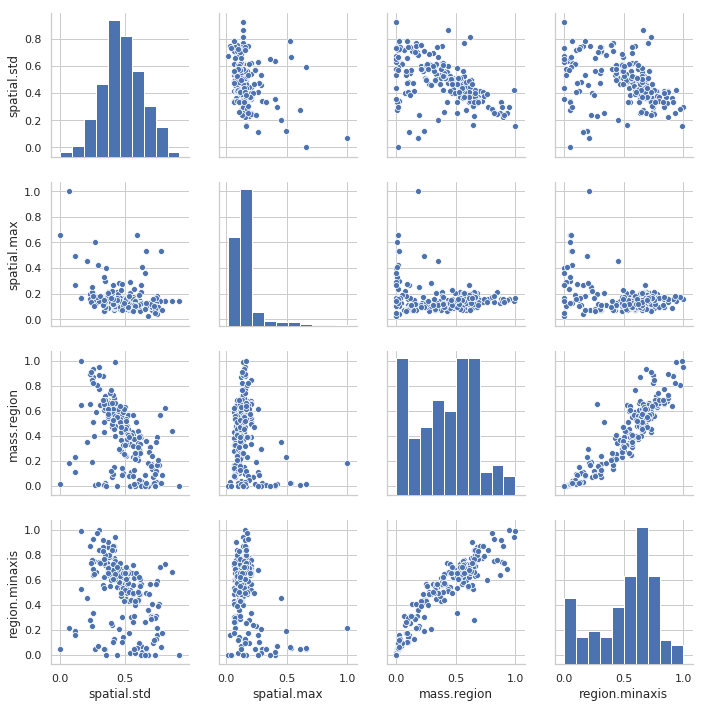

In [5]:
# Spatial metrics visualize
sns.pairplot(data2.fillna(value=0)[['spatial.std', 'spatial.max', 'mass.region', 'region.minaxis']])

# plt.savefig('/home/brian/Documents/figures/min_highfreq_pairplot.png')
plt.show()

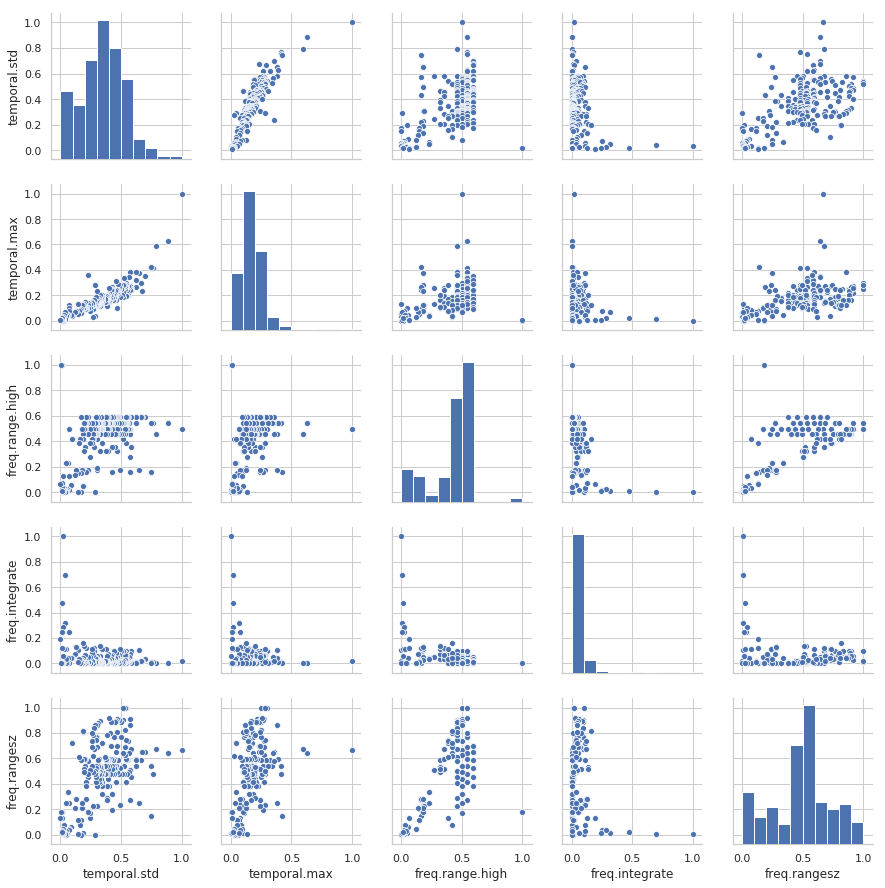

In [6]:
# Temporal metrics visualize  
sns.pairplot(data2.fillna(value=0)[['temporal.std', 'temporal.max', 'freq.range.high', 'freq.integrate', 'freq.rangesz' ]])

# plt.savefig('/home/brian/Documents/figures/min_highfreq_pairplot.png')
plt.show()

# Train your classifier

In [16]:

new_new_vars = [#spetial metrics 
                'spatial.std', 'spatial.min', 'spatial.max', 
                 'mass.perc', 'region.minaxis', 'region.majaxis', 'region.orient', 'threshold.area',
                #temporal metrics
                'temporal.max', 'freq.maxsnr.freq', 'length', 'freq.rangesz']

classConfidence = pd.DataFrame(index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X[new_new_vars], y, test_size=0.3, random_state=42)


## Gaussian Naive Bayes Classifier

In [105]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

gnb = GaussianNB(var_smoothing= 0.25)
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=0.25)

In [106]:
y_pred = gnb.predict(X_test)

print('Accuracy of Gaussian NB classifier on test set: {:.2f}'.format(gnb.score(X_test, y_test)))

Accuracy of Gaussian NB classifier on test set: 0.94


In [107]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
col_list = ['not pred.', 'pred.']
row_list = ['not act.', 'act.']
row_format ="{:>15}" * (len(col_list) + 1)
print(row_format.format("", *col_list))
for rlist, row in zip(row_list, confusion_matrix):
    print(row_format.format(rlist, *row))

                     not pred.          pred.
       not act.             10              0
           act.              4             49


In [92]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.71      1.00      0.83        10
         1.0       1.00      0.92      0.96        53

   micro avg       0.94      0.94      0.94        63
   macro avg       0.86      0.96      0.90        63
weighted avg       0.95      0.94      0.94        63



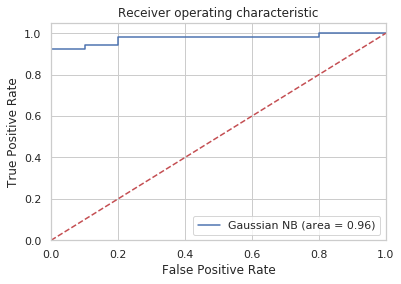

In [93]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

roc_auc = roc_auc_score(y_test, gnb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gnb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gaussian NB (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

classConfidence.loc[X_test.index, 'gnb_prob'] = gnb.predict_proba(X_test)[:,1]
classConfidence.loc[X_train.index, 'gnb_prob'] = gnb.predict_proba(X_train)[:,1]

## Logtistic Regression

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(C=1, solver='lbfgs')
logreg.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [47]:
y_pred = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.94


In [48]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
col_list = ['not pred.', 'pred.']
row_list = ['not act.', 'act.']
row_format ="{:>15}" * (len(col_list) + 1)
print(row_format.format("", *col_list))
for rlist, row in zip(row_list, confusion_matrix):
    print(row_format.format(rlist, *row))

                     not pred.          pred.
       not act.              7              3
           act.              1             52


In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.70      0.78        10
         1.0       0.95      0.98      0.96        53

   micro avg       0.94      0.94      0.94        63
   macro avg       0.91      0.84      0.87        63
weighted avg       0.93      0.94      0.93        63



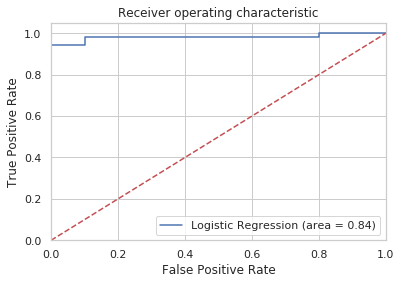

In [50]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

classConfidence.loc[X_test.index, 'logreg_prob'] = logreg.predict_proba(X_test)[:,1]
classConfidence.loc[X_train.index, 'logreg_prob'] = logreg.predict_proba(X_train)[:,1]

# print(data.loc[X_test.index, 'signal'])

# print(logreg.predict_proba(X_test))


## Support Vector Machine Classifer with Gaussian kernel

In [51]:
from sklearn.svm import SVC

svm_clf = SVC(kernel="rbf", gamma=0.01, C=50, random_state=42, probability= True)
svm_clf.fit(X_train, y_train)


SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [52]:
y_pred = svm_clf.predict(X_test)

print('Accuracy of SVM classifier on test set: {:.2f}'.format(svm_clf.score(X_test, y_test)))

Accuracy of SVM classifier on test set: 0.95


In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
col_list = ['not pred.', 'pred.']
row_list = ['not act.', 'act.']
row_format ="{:>15}" * (len(col_list) + 1)
print(row_format.format("", *col_list))
for rlist, row in zip(row_list, confusion_matrix):
    print(row_format.format(rlist, *row))

                     not pred.          pred.
       not act.              8              2
           act.              1             52


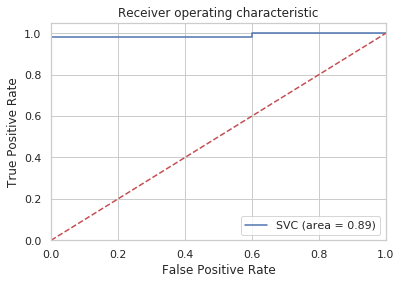

In [54]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

roc_auc = roc_auc_score(y_test, svm_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, svm_clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('SVM_ROC.svg')
plt.show()

classConfidence.loc[X_test.index, 'SVC_prob'] = svm_clf.predict_proba(X_test)[:,1]
classConfidence.loc[X_train.index, 'SVC_prob'] = svm_clf.predict_proba(X_train)[:,1]


## Random Forest Classifier

In [55]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_features = len(new_new_vars), random_state=42)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=12, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [56]:
y_pred = rnd_clf.predict(X_test)

print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rnd_clf.score(X_test, y_test)))

Accuracy of Random Forest classifier on test set: 0.94


In [57]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
col_list = ['not pred.', 'pred.']
row_list = ['not act.', 'act.']
row_format ="{:>15}" * (len(col_list) + 1)
print(row_format.format("", *col_list))
for rlist, row in zip(row_list, confusion_matrix):
    print(row_format.format(rlist, *row))

                     not pred.          pred.
       not act.              9              1
           act.              3             50


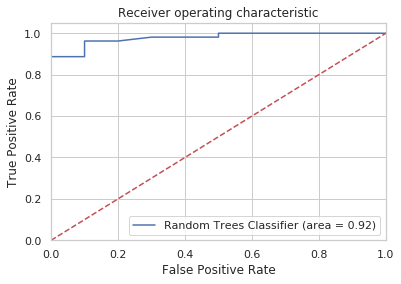

In [58]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

roc_auc = roc_auc_score(y_test, rnd_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rnd_clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Trees Classifier (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('rnd_ROC.svg')
plt.show()

classConfidence.loc[X_test.index, 'rnd_clf_prob'] = rnd_clf.predict_proba(X_test)[:,1]
classConfidence.loc[X_train.index, 'rnd_clf_prob'] = rnd_clf.predict_proba(X_train)[:,1]


## Voting Classifier

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


log_clf = LogisticRegression(C=1, solver = 'lbfgs', random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 50, max_features = len(new_new_vars), random_state=42)
svm_clf = SVC(kernel="rbf", gamma=0.01, C=50, random_state=42, probability= True)
gnb = GaussianNB(var_smoothing= 0.25)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf), ('gnb', gnb_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFores...shrinking=True,
  tol=0.001, verbose=False)), ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [96]:
y_pred = voting_clf.predict(X_test)

print('Accuracy of Voting classifier on test set: {:.2f}'.format(voting_clf.score(X_test, y_test)))

Accuracy of Voting classifier on test set: 0.95


In [97]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
col_list = ['not pred.', 'pred.']
row_list = ['not act.', 'act.']
row_format ="{:>15}" * (len(col_list) + 1)
print(row_format.format("", *col_list))
for rlist, row in zip(row_list, confusion_matrix):
    print(row_format.format(rlist, *row))

                     not pred.          pred.
       not act.             10              0
           act.              3             50


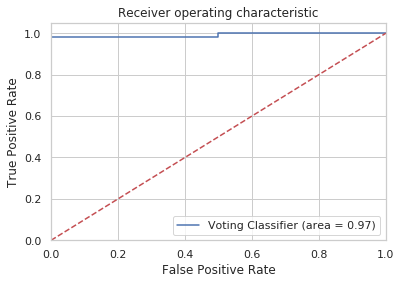

In [98]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

roc_auc = roc_auc_score(y_test, voting_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, voting_clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Voting Classifier (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('rnd_ROC.svg')
plt.show()

classConfidence.loc[X_test.index, 'voting_clf_prob'] = voting_clf.predict_proba(X_test)[:,1]
classConfidence.loc[X_train.index, 'voting_clf_prob'] = voting_clf.predict_proba(X_train)[:,1]


# print(voting_clf.predict_proba(X_test))
# print(voting_clf.predict_proba(X_train))

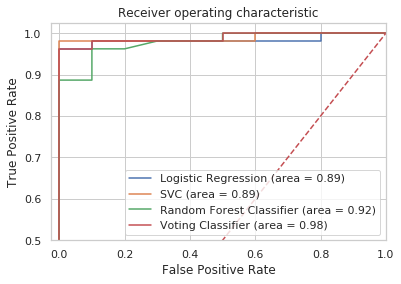

In [100]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.figure()

logreg = LogisticRegression(C=1, solver='lbfgs')
logreg.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)

svm_clf = SVC(kernel="rbf", gamma=0.01, C=50, random_state=42, probability= True)
svm_clf.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, svm_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, svm_clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='SVC (area = %0.2f)' % roc_auc)

rnd_clf = RandomForestClassifier(n_estimators = 500, max_features = len(new_new_vars), random_state=42)
rnd_clf.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, rnd_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rnd_clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Random Forest Classifier (area = %0.2f)' % roc_auc)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, voting_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, voting_clf.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Voting Classifier (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.025, 1.0])
plt.ylim([.50, 1.025])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('rnd_ROC.svg')
plt.show()

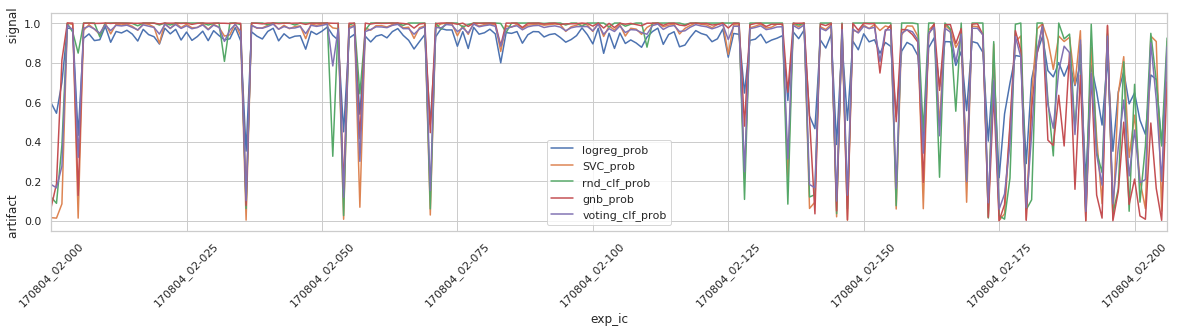

In [101]:
classConfidence.plot(y=['logreg_prob', 'SVC_prob', 'rnd_clf_prob', 'gnb_prob', 'voting_clf_prob'],
                     figsize=(20,4), rot = 45, grid=True)
plt.ylabel('artifact                                       signal')
plt.savefig(path + 'classifier_prob.png')
plt.show()

# High Dimension Visualization

               class
exp_ic              
170804_02-000    0.0
170804_02-001    0.0
170804_02-002    0.0
170804_02-003    0.0
170804_02-004    0.0

Indices used to train that are signal and predicted as signal
170804_02-003	170804_02-004	170804_02-006	170804_02-007	170804_02-008	170804_02-010	170804_02-011	170804_02-012	170804_02-013	170804_02-014	170804_02-017	170804_02-020	170804_02-021	170804_02-022	170804_02-023	170804_02-026	170804_02-027	170804_02-028	170804_02-031	170804_02-032	170804_02-033	170804_02-034	170804_02-035	170804_02-037	170804_02-039	170804_02-040	170804_02-041	170804_02-042	170804_02-043	170804_02-044	170804_02-046	170804_02-047	170804_02-048	170804_02-049	170804_02-050	170804_02-051	170804_02-053	170804_02-058	170804_02-059	170804_02-061	170804_02-062	170804_02-063	170804_02-064	170804_02-071	170804_02-072	170804_02-074	170804_02-076	170804_02-077	170804_02-078	170804_02-079	170804_02-080	170804_02-081	170804_02-083	170804_02-085	170804_02-087	170804_02-088	170804

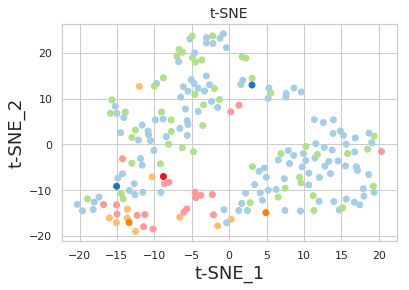

In [76]:
# all data without exclusion
from sklearn.manifold import TSNE
import plotly.plotly as py
import plotly.graph_objs as go
from operator import add
import plotly

plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# a = np.arange(data.shape[0]).astype(str).tolist()
# a = ['domain ' + str(i) for i in a]
# b = ['  class ' + str(i) for i in classify]

# text = list(map(add, a, b))

tsne = TSNE(n_components=2, 
            perplexity=20, # between 5 and 50 only 
            learning_rate = 300,
            random_state=42)
X_reduced_tsne = tsne.fit_transform(X[new_new_vars])


color = pd.DataFrame(index=data.index)

y_test_pred = voting_clf.predict(X_test)
y_train_pred = voting_clf.predict(X_train)

X_train_index = X_train.index.values
X_test_index = X_test.index.values

y_train_value = np.squeeze(y_train)
y_test_value = np.squeeze(y_test)

color['class'] = np.zeros(len(color))
print(color.head())


for j, ind in enumerate(X_train_index):
    if y_train_pred[j]==0:
        color.at[ind, 'class'] += 4
    if y_train_pred[j] != y_train_value[j]: # make odd if inaccurate prediction
        color.at[ind, 'class'] += 1

for j, ind in enumerate(X_test_index):
    color.at[ind, 'class'] +=2
    if y_test_pred[j]==0:
        color.at[ind, 'class'] += 4
    if y_test_pred[j] != y_test_value[j]:
        color.at[ind, 'class'] += 1
        
        
print('\nIndices used to train that are signal and predicted as signal')
print(*color.loc[color['class']==0].index, sep='\t')

print('\nIndices used to train that are signal and are predicted as NOT signal')
print(*color.loc[color['class']==1].index, sep='\t')

print('\nIndices used to test that are signal and and are predicted as signal')
print(*color.loc[color['class']==2].index, sep='\t')

print('\nIndices used to test that are signal and are predicted as NOT signal')
print(*color.loc[color['class']==3].index, sep='\t')

print('\nIndices used to train that are NOT signal and are predicted as NOT signal')
print(*color.loc[color['class']==4].index, sep='\t')

print('\nIndices used to train that are NOT signal and are predicted as signal')
print(*color.loc[color['class']==5].index, sep='\t')

print('\nIndices used to test that are NOT signal and are predicted as NOT signal')
print(*color.loc[color['class']==6].index, sep='\t')

print('\nIndices used to test that are NOT signal and are predicted as signal')
print(*color.loc[color['class']==7].index, sep='\t')


## NOT WORKING!!
# l = []
# trace0= go.Scatter(
#     x= X_reduced_tsne[:, 0],
#     y= X_reduced_tsne[:, 1],
#     mode= 'markers',
#     marker= dict(size= 20,
#                 line= dict(width=1),
#                 colorbar =dict(title='effectiveness of training',
#                                 tickvals = [1,3,5,7],
#                                 ticktext = ['Signal train','Not signal train','Signal test', 'Not signal test'],
# #                                 opacity= 0.7,
# #                                 cmax =12
#                ),
#     color= color,
#     colorscale=[[0, 'rgb(170,205,225)'],[1/8, 'rgb(32,120,185)'], [2/8, 'rgb(175,226,132)'],[3/8, 'rgb(50,162,42)'],
#                 [4/8, 'rgb(255,151,157)'], [5/8, 'rgb(222,28,29)'], [6/8, 'rgb(253,189,109)'], [7/8, 'rgb(255,125,2)']],
# #      name= 'Domain',
#                 ))#,hoverinfo = text)
# # The hover text goes here...


# layout= go.Layout(
#     title= 't-SNE',
#     hovermode= 'closest',
#     xaxis= dict(
#         title= 't-sne1',
#         ticklen= 5,
#         zeroline= False,
# #         gridwidth= 2,
#         showgrid = True
#     ),
#     yaxis=dict(
#         title= 't-sne2',
#         ticklen= 5,
# #         gridwidth= 2,
#         zeroline = False,
#         showgrid =True

#     ),
#     showlegend= False,
# )

# fig = go.Figure(data=[trace0], layout=layout)
# py.iplot(fig, filename='jupyter-Freq vs minor axis of Brain regions')


# fig = plt.figure(figsize = (20,20))
plt.title('t-SNE', fontsize=14)
cax = plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=color['class'], cmap='Paired', vmax = 12)
plt.xlabel("t-SNE_1", fontsize=18)
plt.ylabel("t-SNE_2", fontsize=18)
plt.grid(True)
cbar = fig.colorbar(cax, ticks=np.arange(0,12,2))
cbar.ax.set_xticklabels(['train signal', 'train other', 'test signal', 'test other'])  # horizontal colorbar
# plt.colorbar()
# plt.savefig("other_dim_reduction_plot")
plt.show()

In [4]:
# save the classifier
path = '/home/brian/Documents/data/Classifier/'
file = '170804_02_ica.hdf5'

print(path + 'p21_classifier.sav')

voting_clf = joblib.load(path + 'p21_classifier.sav')

new_new_vars = ['region.orient', 'mass.region', 'region.minaxis',
                'threshold.area', 'region.majaxis',
                'spatial.std', 'spatial.min', 'spatial.max', 
                #temporal metrics
                'freq.maxsnr.freq', 'temporal.autocorr', 'temporal.min', 'temporal.max']

h = h5(path + 'p21_classifier.hdf5')
h.save({'classifier':voting_clf, 'metrics':new_new_vars})


/home/brian/Documents/data/Classifier/p21_classifier.sav
		Failed..
classifier did not save
type: VotingClassifier

/home/brian/Documents/data/Classifier/p21_classifier.hdf5 has no keys.
/home/brian/Documents/data/Classifier/p21_classifier.hdf5 has the following attributes:
	- metrics



## Within the same animal

In [85]:
# load the classifer
loaded_model = joblib.load(path + 'p21_classifier.sav')

# test a new dataset
#Open file
path = '/home/brian/Documents/data/Classifier/'
file = '170804_03_ica.hdf5'

tsv_output_file = path + file[:9] + '_ica_metrics.tsv'
new_data = pd.DataFrame.from_csv(tsv_output_file, sep = '\t')

# Load the noise and artifact components
g = h5(path + file)
yselected = g.load('artifact_components')
noise = g.load('noise_components')

signal = np.where(noise!=1)[0]

#puts the paramter on a scale of 0 to 1
new_data -= new_data.min()
new_data /= new_data.max()

X_new = new_data.fillna(value=0).loc[signal, new_new_vars]
predict_y = loaded_model.predict(X_new)

In [ ]:
#updating dataframe
#Open file
path = '/home/brian/Documents/data/Classifier/'
file = '170804_02_ica.hdf5'

tsv_output_file = path + file[:9] + '_ica_metrics.tsv'
data = pd.DataFrame.from_csv(tsv_output_file, sep = '\t')

#Load classifications
h = h5(path + file)
print(h.keys())
noise = h.load('noise_components')
artifact = h.load('artifact_components')

noise = noise*2
classify = artifact + noise
classify[classify==3] = 1

nois_index = np.where(classify == 2)
art_index = np.where(classify ==1)
sig_index = np.where(classify == 0)




Accuracy of Voting classifier on new dataset: 0.98


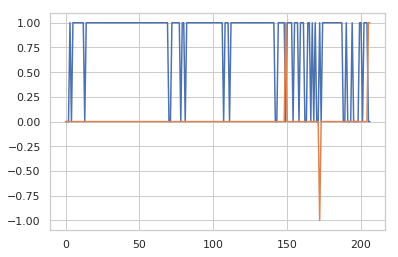

[149 172 205 206]


In [87]:
yselected = yselected[signal]

print('Accuracy of Voting classifier on new dataset: {:.2f}'.format(loaded_model.score(X_new, np.abs(yselected.astype('float32')-1))))
p_y = np.abs(predict_y-1)

plt.plot(np.abs(yselected.astype('float32')-1))
plt.plot(yselected-p_y)
plt.show()

dif = yselected-p_y
print(np.where(dif!=0)[0])

# Between animals of the same age and genotype

In [98]:
# load the classifer
loaded_model = joblib.load(path + 'p21_classifier.sav')

# test a new dataset
#Open file
path = '/home/brian/Documents/data/Classifier/'
file = '171003_05_ica.hdf5' #other P21 data

tsv_output_file = path + file[:9] + '_ica_metrics.tsv'
new_data = pd.DataFrame.from_csv(tsv_output_file, sep = '\t')

# Load the noise and artifact components
g = h5(path + file)
yselected = g.load('artifact_components')
noise = g.load('noise_components')

signal = np.where(noise!=1)[0]

#puts the paramter on a scale of 0 to 1
new_data -= new_data.min()
new_data /= new_data.max()

X_new = new_data.fillna(value=0).loc[signal, new_new_vars]
predict_y = loaded_model.predict(X_new)

Accuracy of Voting classifier on new dataset: 0.91


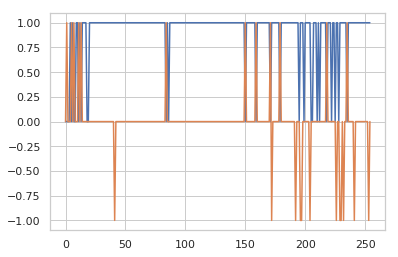

Signal that was identified as artifact
[ 41 172 192 196 197 204 226 229 230 232 241 253]

Artifact that was identified as Signal
[  1   5   7  11  13  84 150 159 171 179 218 235]


In [103]:
yselected = yselected[signal]

print('Accuracy of Voting classifier on new dataset: {:.2f}'.format(loaded_model.score(X_new, np.abs(yselected.astype('float32')-1))))
p_y = np.abs(predict_y-1)

plt.plot(np.abs(yselected.astype('float32')-1))
plt.plot(yselected-p_y)
plt.show()

dif = yselected-p_y
print('Signal that was identified as artifact')
print(np.where(dif<0)[0])
print('\nArtifact that was identified as Signal')
print(np.where(dif>0)[0])

## Between animals of a different age and genotype

In [93]:
# load the classifer
loaded_model = joblib.load(path + 'p21_classifier.sav')

# test a new dataset
#Open file
path = '/home/brian/Documents/data/Classifier/'
file = '171003_01_ica.hdf5' # ephrin a5ko p6

tsv_output_file = path + file[:9] + '_ica_metrics.tsv'
new_data = pd.DataFrame.from_csv(tsv_output_file, sep = '\t')

# Load the noise and artifact components
g = h5(path + file)
yselected = g.load('artifact_components')
noise = g.load('noise_components')

signal = np.where(noise!=1)[0]

#puts the paramter on a scale of 0 to 1
new_data -= new_data.min()
new_data /= new_data.max()

X_new = new_data.fillna(value=0).loc[signal, new_new_vars]
predict_y = loaded_model.predict(X_new)

In [1]:
# all data without exclusion
from sklearn.manifold import TSNE

data2 = data.fillna(value=0).copy()
tsne = TSNE(n_components=2)
X_reduced_tsne = tsne.fit_transform(data2.values)

plt.title('t-SNE', fontsize=14)
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=classify[:X_reduced_tsne.shape[0]], cmap='jet')
plt.xlabel("t-SNE_1", fontsize=18)
plt.ylabel("t-SNE_2", fontsize=18)
plt.grid(True)

# save_fig("other_dim_reduction_plot")
plt.show()

NameError: name 'data' is not defined

In [36]:
include = ['mass.perc','region.orient', 'threshold.perc', 'region.eccentricity', 
           'temporal.autocorr','temporal.std','freq.integrate', 'freq.avgsnr','freq.range.low',
          'freq.range.high']

data3 = data[include].copy()

data3['relative.position.x'] = data['spatial.COMdom.x']/roimask.shape[0]
data3['relative.position.y'] = data['spatial.COMdom.y']/roimask.shape[0]
data3['ratio.axis'] = data['region.minaxis']/data['region.majaxis']

#spatial.COMdom.x/roimask.shape[0]
#spatial.COMdom.y/roimask.shape[1]
#region.minaxis/region.majaxis
for item in data3:
    print(item)

data3.head()

mass.perc
region.orient
threshold.perc
region.eccentricity
temporal.autocorr
temporal.std
freq.integrate
freq.avgsnr
freq.range.low
freq.range.high
relative.position.x
relative.position.y
ratio.axis


,mass.perc,region.orient,threshold.perc,region.eccentricity,temporal.autocorr,temporal.std,freq.integrate,freq.avgsnr,freq.range.low,freq.range.high,relative.position.x,relative.position.y,ratio.axis
0,0.104078,-1.533131,0.908637,0.976892,0.988969,24.240588,0.552086,1.480212,0.220971,1.621049,0.316645,0.598947,0.213732
1,0.087115,1.535021,0.860614,0.990216,0.991236,18.898220,0.462642,1.486825,0.202631,1.486509,0.213077,0.598152,0.139540
2,0.050139,-1.529622,0.522533,0.956710,0.985583,16.939921,0.952586,1.648356,0.220971,1.486509,0.479980,0.586989,0.291043
3,0.050953,1.393631,0.546201,0.941773,0.992428,16.937557,1.309792,1.708909,0.078125,1.363135,0.380206,0.527305,0.336250
4,0.062334,-1.112067,0.859321,0.634755,0.985495,16.899147,0.609830,1.484418,0.240970,1.486509,0.326746,0.615186,0.772713


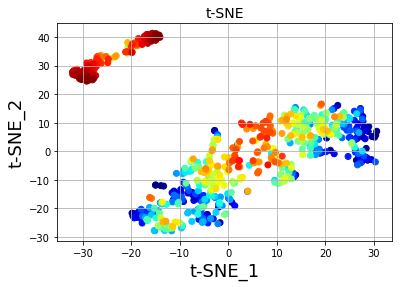

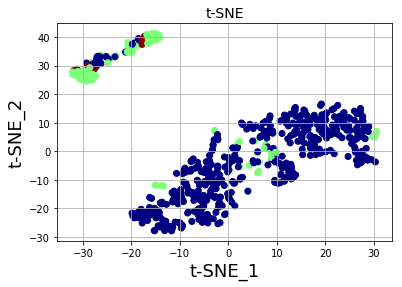

In [55]:
data3.fillna(value=0, inplace = True)
data3 -= data3.min()
data3 /= data3.max()
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(data3.values)

plt.title('t-SNE', fontsize=14)
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=np.arange(X_reduced_tsne.shape[0]), cmap='jet')
plt.xlabel("t-SNE_1", fontsize=18)
plt.ylabel("t-SNE_2", fontsize=18)
plt.grid(True)
plt.show()

plt.title('t-SNE', fontsize=14)
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=classify[:X_reduced_tsne.shape[0]], cmap='jet')
plt.xlabel("t-SNE_1", fontsize=18)
plt.ylabel("t-SNE_2", fontsize=18)
plt.grid(True)
# save_fig("other_dim_reduction_plot")
plt.show()

In [57]:
include = ['freq.maxsnr', 
           'freq.avgsnr',
           'length',
           'spatial.max',
           'spatial.std', 
           'region.minaxis', 
           'region.extent', 
           'region.eccentricity', 
           'temporal.autocorr',
           'freq.integrate',
           'mass.region', 
           'mass.perc',
           'temporal.std',
           'threshold.perc',
           'temporal.max',
           'temporal.min',
           'freq.range.high',
           'freq.range.low',
           'region.majmin.ratio']

data4 = data[include].copy()

#spatial.COMdom.x/roimask.shape[0]
#spatial.COMdom.y/roimask.shape[1]
#region.minaxis/region.majaxis
# print(list(data))

# data4.apply(np.log2).head()

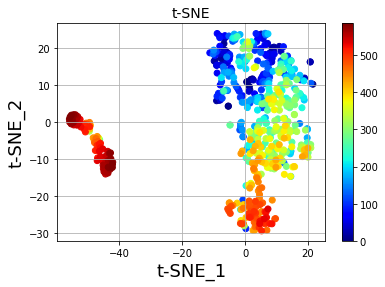

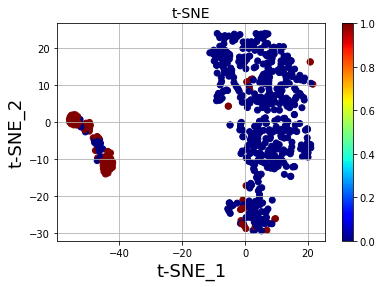

In [64]:
data4.fillna(value=0, inplace = True)

data4 -= data4.min()
data4 /= data4.max()
tsne = TSNE(n_components=2, random_state=1)

data5 = data4.loc[(classify == 1)|(classify == 0)]
c = classify[(classify == 1)|(classify == 0)]

X_reduced_tsne = tsne.fit_transform(data5.values)

plt.title('t-SNE', fontsize=14)
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=np.arange(X_reduced_tsne.shape[0]), cmap='jet')
plt.xlabel("t-SNE_1", fontsize=18)
plt.ylabel("t-SNE_2", fontsize=18)
plt.grid(True)
plt.colorbar()
plt.show()

plt.title('t-SNE', fontsize=14)
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=c, cmap='jet')
plt.xlabel("t-SNE_1", fontsize=18)
plt.ylabel("t-SNE_2", fontsize=18)
plt.grid(True)
# save_fig("other_dim_reduction_plot")
plt.colorbar()
plt.show()

# X_reduced_tsne = tsne.fit_transform(data4.values)

# plt.title('t-SNE', fontsize=14)
# plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=np.arange(X_reduced_tsne.shape[0]), cmap='jet')
# plt.xlabel("t-SNE_1", fontsize=18)
# plt.ylabel("t-SNE_2", fontsize=18)
# plt.grid(True)
# plt.colorbar()
# plt.show()

# plt.title('t-SNE', fontsize=14)
# plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=classify, cmap='jet')
# plt.xlabel("t-SNE_1", fontsize=18)
# plt.ylabel("t-SNE_2", fontsize=18)
# plt.grid(True)
# # save_fig("other_dim_reduction_plot")
# plt.colorbar()
# plt.show()

In [67]:
#Three groups
group1 = np.where(X_reduced_tsne[:, 0] < -20)
print('\nNoise and blood artifacts: \n', group1)
# group1b = np.where((X_reduced_tsne[:, 0] < 0) & (X_reduced_tsne[:, 0] > -9))
# print('\n\tClosest blood components to neuronal: \n\t', group1b)
group2 = np.where((X_reduced_tsne[:, 0] < -20) & (c == 1))
print('\t\nNoise components labeled artifact: \n\t', group2)
group3 = np.where((X_reduced_tsne[:, 0] < -20) & (c == 0))
print('\t\nNoise components labeled as signal: \n\t', group3)

group4 = np.where(X_reduced_tsne[:, 0] > -20)
print('\nNeural components: \n', group4)
group5 = np.where((X_reduced_tsne[:, 0] > -20) & (c == 1))
print('\n\tNeural components labeled artifact: \n\t', group5)
group6 = np.where((X_reduced_tsne[:, 0] > -20) & (c == 0))
print('\n\tNueral components labeled as signal: \n\t', group6)

group7 = np.where((X_reduced_tsne[:, 0] > -20) & (X_reduced_tsne[:, 1] > -10))
print('\n\tNueral components labeled as signal: \n\t', group7)
group8 = np.where((X_reduced_tsne[:, 0] > -20) & (X_reduced_tsne[:, 1] > -10)  & (c == 1))
print('\n\tNueral components labeled as artifact: \n\t', group8)
group9 = np.where((X_reduced_tsne[:, 0] > -20) & (X_reduced_tsne[:, 1] > -10)  & (c == 0))
print('\n\tNueral components labeled as signal: \n\t', group9)


group7 = np.where((X_reduced_tsne[:, 0] >- 20) & (X_reduced_tsne[:, 1] < -10))
print('\n\tNueral components labeled as signal: \n\t', group7)
group8 = np.where((X_reduced_tsne[:, 0] >- 20) & (X_reduced_tsne[:, 1] < -10)  & (c == 1))
print('\n\tNueral components labeled as artifact: \n\t', group8)
group9 = np.where((X_reduced_tsne[:, 0] >- 20) & (X_reduced_tsne[:, 1] < -10)  & (c == 0))
print('\n\tNueral components labeled as signal: \n\t', group9)

# group3a = np.where((X_reduced_tsne[:, 0] > -5) & (X_reduced_tsne[:, 1] < -3))
# group3b = np.where((X_reduced_tsne[:, 0] > -5) & (X_reduced_tsne[:, 0] < 5) & (X_reduced_tsne[:, 1] > -3))
# group3c = np.where((X_reduced_tsne[:, 0] > 10))
# print('\n\tLowest group of neural components (visual cortex): \n\t', group3a)
# print('\n\tMiddle group of neural components (OB and autitory): \n\t', group3b)
# print('\n\tHighest group of neural compoents (the rest) \n\t', group3c)



Noise and blood artifacts: 
 (array([287, 329, 361, 364, 416, 427, 440, 444, 445, 457, 458, 465, 473,
       474, 478, 487, 497, 506, 507, 509, 514, 515, 516, 517, 519, 520,
       521, 523, 526, 527, 530, 531, 532, 534, 535, 537, 538, 539, 540,
       541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553,
       554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566,
       567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579,
       580, 581, 582, 583, 584, 585, 586]),)
	
Noise components labeled noise: 
	 (array([329, 361, 364, 416, 427, 440, 444, 457, 458, 465, 487, 509, 514,
       515, 519, 523, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547,
       548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560,
       561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573,
       574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586]),)
	
Noise components labeled as signal: 
	 (array([287, 445, 473, 474, 478, 497, 506, 507, 51